# **Introduction**
Image caption Generator is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have a great impact, by helping visually impaired people better understand the content of images. 

This task is significantly harder in comparison to the image classification or object recognition tasks that have been well researched. 

The biggest challenge is most definitely being able to create a description that must capture not only the objects contained in an image, but also express how these objects relate to each other.

# **Approach to the problem statement**
We will tackle this problem using an Encoder-Decoder model. Here our encoder model will combine both the encoded form of the image and the encoded form of the text caption and feed to the decoder.

Our model will treat CNN as the ‘image model’ and the RNN/LSTM as the ‘language model’ to encode the text sequences of varying length. The vectors resulting from both the encodings are then merged and processed by a Dense layer to make a final prediction.

We will create a merge architecture in order to keep the image out of the RNN/LSTM and thus be able to train the part of the neural network that handles images and the part that handles language separately, using images and sentences from separate training sets. 

In our merge model, a different representation of the image can be combined with the final RNN state before each prediction.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/10/Screenshot-2020-10-20-at-7.36.38-PM-768x289.png)

The above diagram is a visual representation of our approach.

The merging of image features with text encodings to a later stage in the architecture is advantageous and can generate better quality captions with smaller layers than the traditional inject architecture (CNN as encoder and RNN as a decoder).

To encode our image features we will make use of transfer learning. There are a lot of models that we can use like VGG-16, InceptionV3, ResNet, etc.
We will make use of the inceptionV3 model which has the least number of training parameters in comparison to the others and also outperforms them.

To encode our text sequence we will map every word to a 200-dimensional vector. For this will use a pre-trained Glove model. This mapping will be done in a separate layer after the input layer called the embedding layer.

To generate the caption we will be using two popular methods which are Greedy Search and Beam Search. These methods will help us in picking the best words to accurately define the image.

I hope this gives you an idea of how we are approaching this problem statement.


Let’s dive into the implementation and creation of an image caption generator!

In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

# **Data loading and Preprocessing**

In this project, we will use UIT-ViIC dataset with Vietnamese language. 

In [2]:
train_token_path = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/train/captions.txt"
val_token_path = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/val/captions.txt"
test_token_path = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/test/captions.txt"

train_images = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/train/images"
val_images = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/val/images"
test_images = "/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset/test/images"

train_doc = open(train_token_path, 'r').read()
val_doc = open(val_token_path, 'r').read()
test_doc = open(test_token_path, 'r').read()

print(train_doc[:458])

/dataset/train/images/000000157656.jpg	Người đàn ông đang đánh tennis ngoài sân.
/dataset/train/images/000000157656.jpg	Một vận động viên tennis đang vung vợt đánh bóng.
/dataset/train/images/000000157656.jpg	Một cầu thủ tennis đang vung vợt tennis đỡ bóng.
/dataset/train/images/000000157656.jpg	Người đàn ông đang đứng ngoài biên cầm vợt sẵn sàng đỡ bóng.
/dataset/train/images/000000157656.jpg	Vận động viên tennis nam đang trong tư thế chuẩn bị đỡ bóng.



In [3]:
def format_content(doc):
    descriptions = dict()
    for line in doc.split('\n'):
            tokens = line.split()
            if len(line) > 2:
                image_info = tokens[0].split('/')[-1]
                image_id = image_info.split('.')[0]
                image_desc = ' '.join(tokens[1:])
                if image_id not in descriptions:
                    descriptions[image_id] = list()
                descriptions[image_id].append(image_desc)
    return descriptions

train_descriptions = format_content(train_doc)
val_descriptions = format_content(val_doc)
test_descriptions = format_content(test_doc)

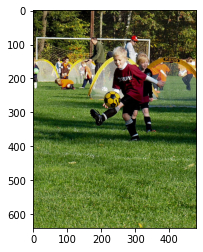

['Trên sân cỏ , một cậu bé đang giơ chân lên để đá quả bóng .',
 'Một cậu bé đang đá quả bóng trong khi một cậu bé khác đang đứng ở phía sau .',
 'Một nhóm người đang chơi đùa trên sân cỏ .',
 'Trên sân cỏ , hai cầu thủ bóng đá đang luyện tập .',
 'Trên sân cỏ , một cầu thủ đang giơ chân lên để đá quả bóng .']

In [4]:
vit_pic = '000000000368.jpg'
x = plt.imread(train_images + '/' + vit_pic)
plt.imshow(x)
plt.show()
train_descriptions['000000000368']

Next, we create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions in the data set. We have 9630 unique words across all the 40000 image captions.

In [5]:
def create_vocab(descriptions, vocab = None):
    if vocab != None:
        vocabulary = vocab
    else:
        vocabulary = set()
    for key in descriptions.keys():
            [vocabulary.update(d.split()) for d in descriptions[key]]
    print('Original Vocabulary Size: %d' % len(vocabulary))
    return vocabulary

vocabulary = create_vocab(train_descriptions)
vocabulary = create_vocab(val_descriptions, vocabulary)

Original Vocabulary Size: 1406
Original Vocabulary Size: 1604


Now let’s save the image id’s and their new cleaned captions in the same format as the token.txt file:-

In [6]:
def create_new_description(descriptions, orig=None):
    if orig != None:
        lines = orig
    else:
        lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    new_descriptions = '\n'.join(lines)
    return new_descriptions

new_train_descriptions = create_new_description(train_descriptions)
new_val_descriptions = create_new_description(val_descriptions)
new_test_descriptions = create_new_description(test_descriptions)

Next, we load all training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file:-

Now,we load all training image and validation image ids in two variables from UIT-ViIC dataset. 

In [7]:
train = set(train_descriptions.keys())
val = set(val_descriptions.keys())
test = set(test_descriptions.keys())

Now we save all the training and testing images in train_img and test_img lists respectively:-

In [8]:
train_img = os.listdir(train_images)
val_img = os.listdir(val_images)
test_img = os.listdir(test_images)

In [9]:
train_img

['000000082091.jpg',
 '000000303548.jpg',
 '000000157593.jpg',
 '000000090572.jpg',
 '000000102451.jpg',
 '000000134454.jpg',
 '000000492417.jpg',
 '000000334283.jpg',
 '000000450477.jpg',
 '000000506550.jpg',
 '000000195851.jpg',
 '000000504091.jpg',
 '000000550444.jpg',
 '000000492840.jpg',
 '000000552254.jpg',
 '000000518916.jpg',
 '000000556216.jpg',
 '000000099336.jpg',
 '000000143346.jpg',
 '000000018688.jpg',
 '000000181278.jpg',
 '000000053081.jpg',
 '000000253251.jpg',
 '000000578226.jpg',
 '000000551633.jpg',
 '000000558808.jpg',
 '000000233968.jpg',
 '000000282147.jpg',
 '000000460491.jpg',
 '000000218294.jpg',
 '000000502776.jpg',
 '000000133060.jpg',
 '000000418772.jpg',
 '000000432432.jpg',
 '000000575135.jpg',
 '000000033429.jpg',
 '000000268293.jpg',
 '000000057461.jpg',
 '000000470832.jpg',
 '000000432873.jpg',
 '000000041962.jpg',
 '000000360762.jpg',
 '000000218116.jpg',
 '000000307967.jpg',
 '000000104417.jpg',
 '000000468284.jpg',
 '000000547300.jpg',
 '00000028944

Now, we load the descriptions of the training images into a dictionary. However, we will add two tokens in every caption, which are ‘startseq’ and ‘endseq’:-

In [10]:
def add_token(description, id_list):
    descriptions = dict()
    for line in description.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in id_list:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = add_token(new_train_descriptions, train)
val_descriptions = add_token(new_val_descriptions, val)
test_descriptions = add_token(new_test_descriptions, test)

Create a list of all the training captions:-

In [11]:
def create_captions_list(captions):
    all_captions = []
    for key, val in captions.items():
        for cap in val:
            all_captions.append(cap)
    return all_captions

all_train_captions = create_captions_list(train_descriptions)
all_val_captions = create_captions_list(val_descriptions)
all_test_captions = create_captions_list(test_descriptions)

To make our model more robust we will reduce our vocabulary to only those words which occur at least 2 times in the entire corpus.

If you have a dictionary, **get()** is a method where w is a variable holding the word you're looking up and 0 is the default value. If w is not present in the dictionary, get returns 0.

In [12]:
word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 903


Now we create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.

In [13]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1


We also need to find out what the max length of a caption can be since we cannot have captions of arbitrary length.

In [14]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 36


**Glove Embeddings**

Word vectors map words to a **vector space, where similar words are clustered together and different words are separated**. The advantage of using Glove over Word2Vec is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.

The basic premise behind Glove is **that we can derive semantic relationships between words from the co-occurrence matrix.**

In [15]:
glove_path = '../input/glove6b/'

embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [16]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# **Model Building and Training**

We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the inceptionV3 model.

In [17]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


Since we are using InceptionV3 we need to pre-process our input before feeding it into the model. Hence we define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of Keras.

In [18]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

Now we can go ahead and encode our training and testing images

In [19]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[train_images + '/' + img] = encode(train_images+'/'+img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[test_images + '/' + img] = encode(test_images+'/'+img)


**Now let’s define our model.**
We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

1. Processing the sequence from the text 
2. Extracting the feature vector from the image
3. Decoding the output using softmax by concatenating the above two layers

In [20]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 200)      180800      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

# **Model Training**

Before training the model we need to keep in mind that we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [21]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

Next, compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

We can train the data in batches.

In [23]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[train_images + '/' + key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [24]:
epochs = 15
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/15
898/898 [==============================] - 71s 75ms/step - loss: 3.4020
Epoch 2/15
898/898 [==============================] - 67s 75ms/step - loss: 2.2801
Epoch 3/15
898/898 [==============================] - 67s 74ms/step - loss: 2.0754
Epoch 4/15
898/898 [==============================] - 67s 74ms/step - loss: 1.9638
Epoch 5/15
898/898 [==============================] - 67s 75ms/step - loss: 1.8767
Epoch 6/15
898/898 [==============================] - 67s 75ms/step - loss: 1.8190
Epoch 7/15
898/898 [==============================] - 67s 74ms/step - loss: 1.7660
Epoch 8/15
898/898 [==============================] - 67s 74ms/step - loss: 1.7135
Epoch 9/15
898/898 [==============================] - 67s 75ms/step - loss: 1.6692
Epoch 10/15
898/898 [==============================] - 67s 75ms/step - loss: 1.6292
Epoch 11/15
898/898 [==============================] - 67s 75ms/step - loss: 1.5889
Epoch 12/15
898/898 [==============================] - 68s 76ms/step - loss: 1.5577
E

# **Greedy and Beam Search**

As the model generates a long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called **Greedy Search.**

In [25]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

**Beam Search** is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.

In [26]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# **Evaluation**

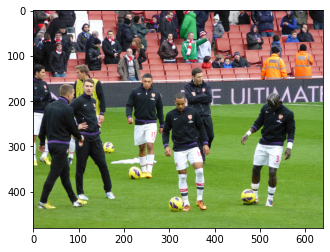

Greedy: Các cầu thủ bóng đá đang thi đấu trên trên sân .
Beam Search, K = 3: Các cầu thủ bóng đá đang thi đấu trên trên sân .
Beam Search, K = 5: Các cầu thủ bóng đá nam của hai đội đang thi đấu trên sân .
Beam Search, K = 7: Các cầu thủ bóng thi đấu bóng đá ở trên sân .


In [30]:
pic = list(encoding_test.keys())[150]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

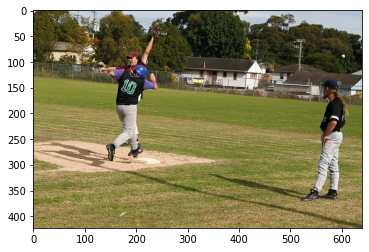

Greedy: Một cầu thủ bóng chày đang thi đấu ở sân sân .
Beam Search, K = 3: Một cầu thủ bóng chày đang thi đấu ở sân sân âm u .
Beam Search, K = 5: Một cầu thủ bóng chày đang thi đấu ở sân sân âm u .
Beam Search, K = 7: Một cầu thủ bóng chày đang thi đấu ở sân sân âm u .


In [31]:
pic = list(encoding_test.keys())[120]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))